# SALARY PREDICTIONS THROUGH 2019 KAGGLE SURVEY

This project aims to deeply understand and explore the skills and credentials in the data science community based on the survey conducted by Kaggle in 2019. In this analysis, the surveys responses will be used to train, validate, and tune regressors to predict a respondent's current annual compensation.

The analysis is divided into the following segments:
1. Data cleaning
2. Exploratory data analysis
3. Feature selection
4. Model implementation
5. Model tuning
6. Testing and discussion

## 1. Data Cleaning

#### Importing all the necessary libraries used for analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import itertools
import seaborn as sb
import matplotlib.style as style
from sklearn.impute import SimpleImputer
import plotly.graph_objs as go
import plotly as py
import plotly.express as px
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline 

In [3]:
df = pd.read_csv("Data/Kaggle_Salary.csv", low_memory=False) # Read the contents of the csv file.
df.head() # Display the contents of the file.

Time from Start to Finish (seconds)     Q1    Q2  Q2_OTHER_TEXT         Q3  \
0                                  510  22-24  Male             -1     France   
1                                  423  40-44  Male             -1      India   
2                                  391  40-44  Male             -1  Australia   
3                                  392  22-24  Male             -1      India   
4                                  470  50-54  Male             -1     France   

                    Q4                 Q5  Q5_OTHER_TEXT  \
0      Master’s degree  Software Engineer             -1   
1  Professional degree  Software Engineer             -1   
2      Master’s degree              Other              0   
3    Bachelor’s degree              Other              1   
4      Master’s degree     Data Scientist             -1   

                     Q6   Q7  ... Q34_Part_6                       Q34_Part_7  \
0  1000-9,999 employees    0  ...        NaN                              NaN   
1    > 10,000 employees  20+  ...        NaN                              NaN   
2    > 10,000 employees  20+  ...        NaN                              NaN   
3        0-49 employees    0  ...        NaN                              NaN   
4        0-49 employees  3-4  ...        NaN  AWS Relational Database Service   

  Q34_Part_8          Q34_Part_9 Q34_Part_10 Q34_Part_11 Q34_Part_12  \
0        NaN                 NaN         NaN         NaN         NaN   
1        NaN                 NaN         NaN         NaN         NaN   
2        NaN  Azure SQL Database         NaN         NaN         NaN   
3        NaN                 NaN         NaN         NaN         NaN   
4        NaN                 NaN         NaN         NaN         NaN   

  Q34_OTHER_TEXT Q10_Encoded    Q10_buckets  
0             -1           3  30,000-39,999  
1             -1           0        0-9,999  
2             -1          14       >250,000  
3             -1           0        0-9,999  
4             -1           6  60,000-69,999  

[5 rows x 248 columns]

### Dropping irrelevant features

By manually going through the questions, the features:
1. 'Time from Start to Finish (seconds)' - Duration
2. Q12 - Who/what are your favorite media sources that report on data science topics?
3. Q19 - What programming language would you recommend an aspiring data scientist to learn first?

are highly subjective and irrelevant with respect to our target variable and hence can be dropped. 

Further observing our dataframe, we can see that the columns with "TEXT" are providing us with values which are not at all required for our analysis. Hence, we will drop such columns from our dataframe.


Instead of going through all the columns and drop them manually, a list has been made which will search all the column names which have the given strings in their names.

In [4]:
i = ['Time from', 'Q19', 'Q12', '_TEXT'] # Creating an array of column names which have the given strings in their name. 

c=[]
for i in i:
    f = df.filter(regex=i) # This will filter out all the columns which have the strings given in the list i, in their names.
    c.append(f.columns)

d = list(itertools.chain.from_iterable(c)) # Gets chained inputs from a single iterable argument that is evaluated lazily.
df = df.drop(columns=d) # Dropping the irrelevant columns.

In [5]:
df.shape # .shape will give us the dimensions of the pandas dataframe.

(12497, 206)

After dropping the irrelevant columns, we now have only 206 columns. 

#### Note:
**This is not the end of data cleaning.**

Data cleaning has been done in data exploration as well.
I was aiming for a separate dataframe only for data exploration and I have performed some of data cleaning steps in the following sections also. 
There were many features to encode but obviously could not drop them for exploration because we also have to impute missing values before exploring the data. 

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## 2. Data exploration

#### Let's clean up and create a new dataframe for data exploration by removing irrelevant features from the original dataframe

#### Note:
Keeping the features which are used for data exploration only. 

Here we will drop all the multiple choice responses.

In [6]:
df_part = df.filter(regex='Part') # No need of such columns for data exploration.
df_exp = df.drop(columns = df_part.columns)
df_exp.head(2)

Q1    Q2      Q3                   Q4                 Q5  \
0  22-24  Male  France      Master’s degree  Software Engineer   
1  40-44  Male   India  Professional degree  Software Engineer   

                     Q6   Q7  \
0  1000-9,999 employees    0   
1    > 10,000 employees  20+   

                                                  Q8            Q10  \
0                                      I do not know  30,000-39,999   
1  We have well established ML methods (i.e., mod...    5,000-7,499   

                 Q11                                                Q14  \
0           $0 (USD)  Basic statistical software (Microsoft Excel, G...   
1  > $100,000 ($USD)  Cloud-based data software & APIs (AWS, GCP, Az...   

                         Q15    Q22        Q23  Q10_Encoded    Q10_buckets  
0                  1-2 years  Never  1-2 years            3  30,000-39,999  
1  I have never written code    NaN        NaN            0        0-9,999

I will also drop few other columns and just keep those which I am going to use for plotting various graphs. 

In [7]:
df_exp = df_exp.drop(columns=['Q14', 'Q7', 'Q8', 'Q10_Encoded', 'Q10'])

As we have our dataframe ready for exploration, let's check whether are there any NaN values present or not.

In [8]:
# Find columns (or features) which have NAN values
list_col = []
for col in df_exp:
    i=df_exp[col].isna().sum()
    if i!=0:
        print(col, "has", i, "NAN values.\n")
        list_col.append(col)
print(list_col)  

Q11 has 247 NAN values.

Q15 has 1075 NAN values.

Q22 has 1947 NAN values.

Q23 has 1956 NAN values.

['Q11', 'Q15', 'Q22', 'Q23']


In [9]:
tot = df_exp.shape[0]
for i in list_col:
    tot_null = df_exp[i].isna().sum()
    perc = (tot_null/tot) *100 
    print("Percentage of null values in ",i ,"are ", "%.3f" %perc, "%")


Percentage of null values in  Q11 are  1.976 %
Percentage of null values in  Q15 are  8.602 %
Percentage of null values in  Q22 are  15.580 %
Percentage of null values in  Q23 are  15.652 %


As the highest percentage of null values in the columns is only around 15%, we can impute the null values with either the mean, mode or the median depending on the type of distribution in each column.

Let's plot the graphs of these columns and visualise the type of ditribution the data holds.

In [10]:
Q11 = df_exp['Q11'].value_counts()
Q11 = Q11.reindex(index=['$0 (USD)','$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '>100,000 (USD)'])
Q15 = df_exp['Q15'].value_counts()
Q15 = Q15.reindex(index=['I have never written code', '< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years'])
Q22 = df_exp['Q22'].value_counts()
Q23 = df_exp['Q23'].value_counts()

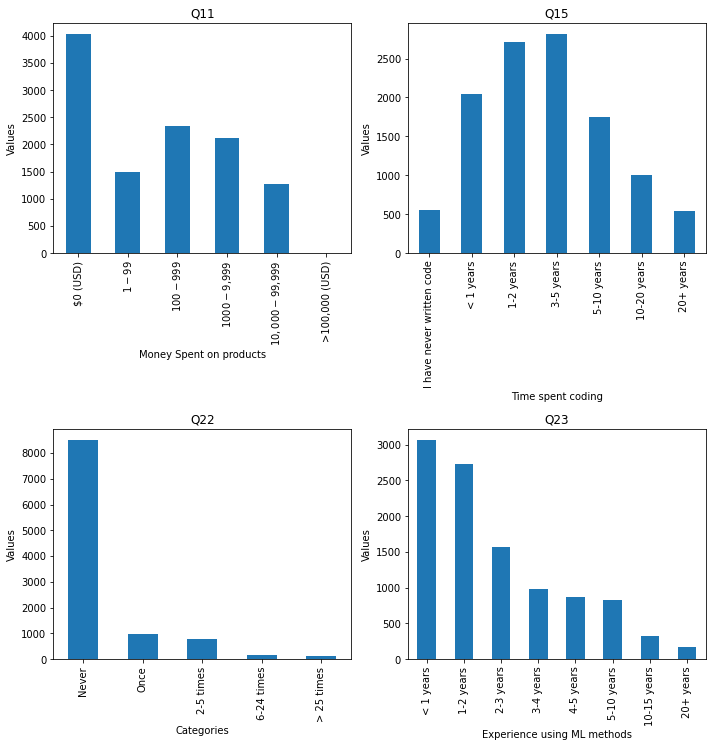

In [11]:
plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
Q11.plot.bar()
plt.title('Q11')
plt.xlabel('Money Spent on products')
plt.ylabel('Values')

plt.subplot(3,2,2)
Q15.plot.bar()
plt.title('Q15')
plt.xlabel('Time spent coding')
plt.ylabel('Values')

plt.subplot(3,2,3)
Q22.plot.bar()
plt.title('Q22')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.subplot(3,2,4)
Q23.plot.bar()
plt.title('Q23')
plt.xlabel('Experience using ML methods')
plt.ylabel('Values')

plt.tight_layout()

From visualizing the graphs, we can say hat the NAN's can be replaced by the most frequent value or the mode of the data.


#### For imputing values in place of missing values

- The mean of the numerical column data is used to replace null values when the data is normally distributed. Median is used if the data comprised of outliers. Mode is used when the data having more occurences of a particular value or more frequent value
- Since q11 is not normally dist., hence selecting mode to replace null values

#### Considering the above graphs for q11, q15, q22 and q23 - 

- q11 = randomly distributed, hence mode will be imputed
- q15 = normally distributed, hence mean will be imputed
- q22 = skewed distribution, hence mode will be imputed
- q23 = skewed distribution, hence mode will be imputed

**In q15, the mean category is also the most frequent category, hence all the questions will be imputed with most frequent entry.**


In [12]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=1)

for col in list_col:
    imp.fit(df_exp[col].values.reshape((-1,1)))
    df_exp[col] = imp.transform(df_exp[col].values.reshape((-1,1)))
    

Checking whether are any NaN values left or not.

In [13]:
df_exp.isna().sum().sum()

0

In [14]:
df_exp.head(2)

Q1    Q2      Q3                   Q4                 Q5  \
0  22-24  Male  France      Master’s degree  Software Engineer   
1  40-44  Male   India  Professional degree  Software Engineer   

                     Q6                Q11                        Q15    Q22  \
0  1000-9,999 employees           $0 (USD)                  1-2 years  Never   
1    > 10,000 employees  > $100,000 ($USD)  I have never written code  Never   

         Q23    Q10_buckets  
0  1-2 years  30,000-39,999  
1  < 1 years        0-9,999

#### Now this dataframe is ready for data exploration.

Percentage of Males: 83.80
Percentage of Females: 14.62
Percentage of people who prefer not to say: 1.34
Percentage of people who would prefer to self-describe: 0.24


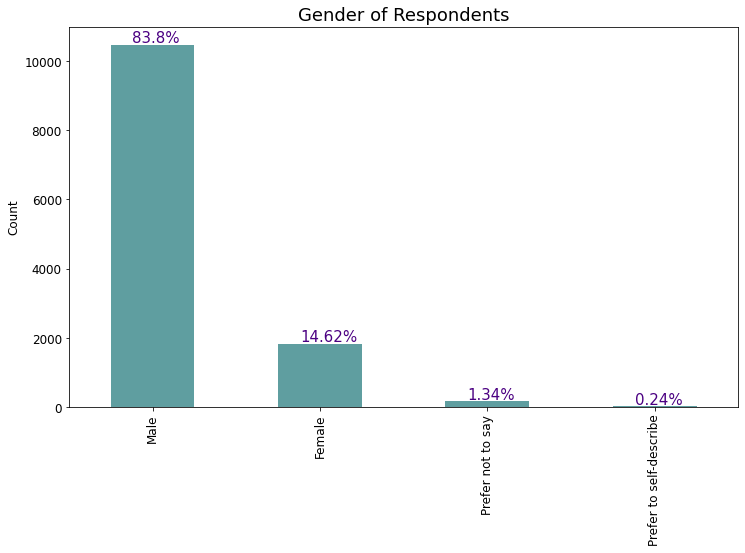

In [15]:
gender = list(df_exp['Q2'].value_counts())

a=print("Percentage of Males: %.2f" %(gender[0]/sum(gender)*100))
b=print("Percentage of Females: %.2f" %(gender[1]/sum(gender)*100))
c=print("Percentage of people who prefer not to say: %.2f" %(gender[2]/sum(gender)*100))
d=print("Percentage of people who would prefer to self-describe: %.2f" %(gender[3]/sum(gender)*100))


ax = df_exp['Q2'].value_counts().plot(kind='bar', figsize=(12,7), fontsize=12, color='cadetblue')
# ax.set_alpha(0.1)
ax.set_title("Gender of Respondents", fontsize=18)
ax.set_ylabel("Count", fontsize=12)


totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+0.13, i.get_height()+60, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='indigo')
    

**Inference -**

This plot represents the gender of repondents.
From this plot, we can say that the majority were Male with 83.8% of total respondents.

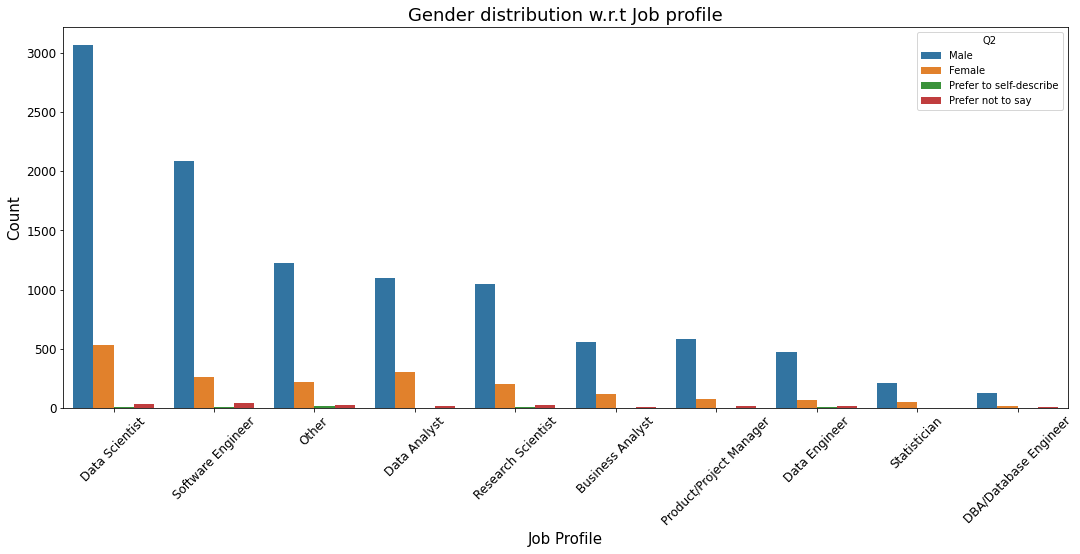

In [16]:
plt.figure(figsize=(18,7))
sb.countplot(x = 'Q5', hue = 'Q2',data = df_exp, order = df_exp['Q5'].value_counts().index)
plt.title("Gender distribution w.r.t Job profile", fontsize=18)
plt.xlabel('Job Profile', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)
plt.show()


**Inference-**

We can analyze from this plot that the majority of respondents were Data Scientists and males dominated each job profile.
In the chart females and males show a similar distribution.

Text(0.5, 1.0, 'Level of education')

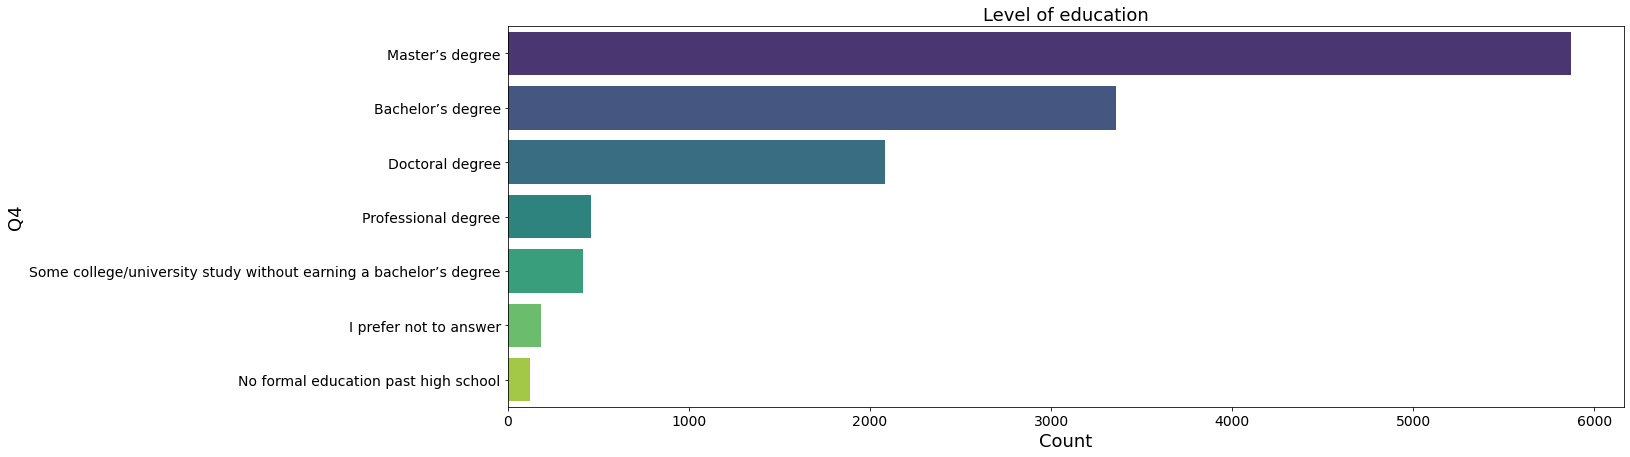

In [17]:
plt.figure(figsize=(20,7))

edu = pd.DataFrame(df_exp['Q4'].value_counts().sort_values(ascending=False)).reset_index()

sb.barplot(x=edu['Q4'],y=edu['index'], palette='viridis')
plt.xlabel('Count', fontsize=18)
plt.ylabel('Q4', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Level of education', fontsize=18)

**Inference-**

The graph obtained above represents the number of respondents from various educational backgrounds. We can see that maximum number of respondents have a Master's degree followed by that of Bachelor's degree and Doctoral degree.

In [18]:
df_ds = df_exp[df_exp['Q5'] == "Data Scientist"]

df_ds_country = df_ds[df_ds['Q3'].isin(df_ds['Q3'].value_counts()[:25].index)].loc[:,["Q3", "Q2"]].groupby(["Q3", "Q2"]).size().reset_index()
df_ds_country.columns = ["Country", "Gender", "Count"]

fig = px.bar(df_ds_country, x="Country", y="Count", color="Gender")

fig.update_layout(title_text='Country Distribution of Data Scientist by Gender',height=500,
                  xaxis={'categoryorder':'total descending'})

fig.show()

**Inference-**

The bar plot describes the country distribution of data scientists by gender.
The maximum number of data scientists reside in United States of America and the majority of them are males. After USA, India holds the 2nd highest number of data scientists and this role is male dominated there too. We can also see that there is a vast difference in number of respondents who are data scientists in the entire world.

In [19]:
df_ds = df_exp[df_exp['Q5'] == "Data Scientist"]

df_ds_sal = df_ds[df_ds['Q10_buckets'].isin(df_ds['Q10_buckets'].value_counts()[:25].index)].loc[:,["Q10_buckets", "Q2"]].groupby(["Q10_buckets", "Q2"]).size().reset_index()
df_ds_sal.columns = ["Salary", "Gender", "Count"]

fig = px.bar(df_ds_sal, x="Salary", y="Count", color="Gender", color_continuous_scale='Inferno')

fig.update_layout(title_text='Salary Distribution of Data Scientist by Gender',height=500,
                  xaxis={'categoryorder':'total descending'})

fig.show()

**Inference-**

The above interactive graph represents the yearly compensation of data scientists by their gender.
The maximum number of repondents have a yearly compensation of 0-9,999 USD $. We can say that the respondents were not comfortable in sharing their true salary. As the choices for this question were in USD, the conversion of one currency to another might also lead to misclassification of data.

In [23]:
df_age = df_exp[['Q1', 'Q2']]
df_age['count'] = 1

<ipython-input-23-029192293847>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
## using pivot table to filter out desired columns

df_age_plot = pd.pivot_table(df_age, values = 'count', index = 'Q1',
                                  columns = 'Q2', aggfunc=np.sum, fill_value=0)

Text(0, 0.5, 'Count of Response')

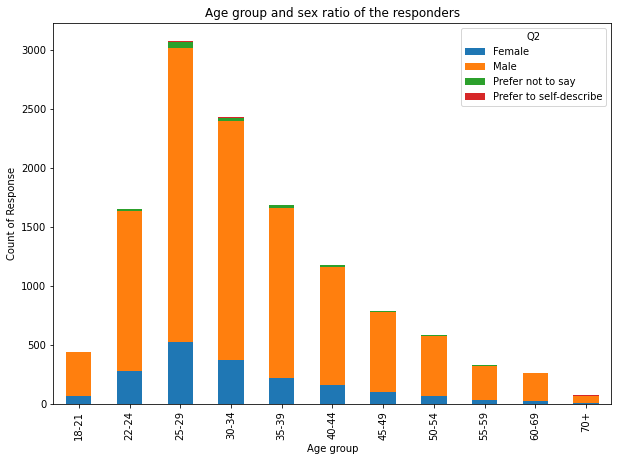

In [26]:
ax2 = df_age_plot.plot.bar(stacked=True, figsize=(10,7))
ax2.set_title("Age group and sex ratio of the responders")
ax2.set_xlabel("Age group")
ax2.set_ylabel("Count of Response")

**Inference** - 

25-29 and 30-34 age groups gave the most responses in the survey and most of them were males

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## 3. Feature selection

### Encoding features

on our original dataframe, we will encoding some of the features which seem necessary before proceeding with imputing the null values.
We can see in the dataframe that most of the null values (NaN) are in the columns (features) which are single/multiple choice questions. 


Such questions have multiple columns where each column represents a option in that question and are hence named 'Part_1, Part_2, etc.
Therefore, we will segregate all such columns by applying a filter and searching through all the columns with the keyword "Part" in it.

In [19]:
# Seperate columns which have "Part" in the column name for creating dummies

df_part = df.filter(regex='Part')


In [20]:
# Drop Q14 columns because they are single choice questions whose dummies cannot be made in this manner
dropped14 = df_part.filter(regex='Q14')

df_part_dropped14 = df_part.drop(columns = dropped14.columns)

This is done so that we can get the name of the columns on which we have to apply the encoding technique.

In [21]:
# Creating a list of name of the columns 
# This list is made to identify the columns to be encoded
q_list = list(df_part_dropped14.columns)
#q_list

##### Encoding is used to convert categorical data, or text data, into numbers, which our predictive models can better understand. 

Label encoding provides a certain number in place of the text which then our prediction model can misinterpret them as weights and consider one data greater than the other. 
As our selected columns have text data in their responses and are unrelated to eat other, we will proceed with one hot encoding technique.
What one hot encoding will do is, it will take a column and then split the column into multiple columns. The text/numbers are replaced by 1s and 0s, depending on which column has what value.


In [22]:
# Implementing One Hot encoding technique using get_dummies
df_new = pd.get_dummies(df, columns= q_list )
df_new.shape

(12497, 206)

In [23]:
df_new.head(2)

Q1    Q2      Q3                   Q4                 Q5  \
0  22-24  Male  France      Master’s degree  Software Engineer   
1  40-44  Male   India  Professional degree  Software Engineer   

                     Q6   Q7  \
0  1000-9,999 employees    0   
1    > 10,000 employees  20+   

                                                  Q8            Q10  \
0                                      I do not know  30,000-39,999   
1  We have well established ML methods (i.e., mod...    5,000-7,499   

                 Q11  ... Q34_Part_3_SQLite Q34_Part_4_Microsoft SQL Server  \
0           $0 (USD)  ...                 0                               0   
1  > $100,000 ($USD)  ...                 0                               0   

  Q34_Part_5_Oracle Database Q34_Part_6_Microsoft Access  \
0                          0                           0   
1                          0                           0   

   Q34_Part_7_AWS Relational Database Service Q34_Part_8_AWS DynamoDB  \
0                                           0                       0   
1                                           0                       0   

   Q34_Part_9_Azure SQL Database  Q34_Part_10_Google Cloud SQL  \
0                              0                             0   
1                              0                             0   

   Q34_Part_11_None  Q34_Part_12_Other  
0                 0                  0  
1                 0                  0  

[2 rows x 206 columns]


Q14 is a single choice question whose dummies are made manually and the columns are then renamed to match the column names of ther such columns. 


In [24]:
# Q14 has been One Hot encoded here
q14_dumm = pd.get_dummies(df_new.Q14)
qlist = q14_dumm.columns
qlist

Index(['Advanced statistical software (SPSS, SAS, etc.)',
       'Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Local development environments (RStudio, JupyterLab, etc.)', 'Other'],
      dtype='object')

In [25]:
# As these new encoded columns are not present in the original dataframe, so these columns have been renamed similar to the ones get_dummies did for the rest 

q14_dumm = q14_dumm.rename(columns={'Advanced statistical software (SPSS, SAS, etc.)': 'Q14 Advanced statistical software (SPSS, SAS, etc.)',\
                                    'Basic statistical software (Microsoft Excel, Google Sheets, etc.)':'Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)',\
                                   'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)': 'Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)', \
                                   'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)':'Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)', \
                                   'Local development environments (RStudio, JupyterLab, etc.)':'Q14 Local development environments (RStudio, JupyterLab, etc.)',\
                                   'Other':'Q14 Other'})
q14_dumm.shape

(12497, 6)

In [26]:
# Creating the column name and values and then inserting it in the original dataframe at the desired location 

addcol = q14_dumm['Q14 Advanced statistical software (SPSS, SAS, etc.)']
addcol1 = q14_dumm['Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)']
addcol2 = q14_dumm['Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)']
addcol3 = q14_dumm['Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)']
addcol4 = q14_dumm['Q14 Local development environments (RStudio, JupyterLab, etc.)']
addcol5 = q14_dumm['Q14 Other']


df_new.insert(loc=12, column='Q14 Advanced statistical software (SPSS, SAS, etc.)', value=addcol)
df_new.insert(loc=13, column='Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)', value=addcol1)
df_new.insert(loc=14, column='Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)', value=addcol2)
df_new.insert(loc=15, column='Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)', value=addcol3)
df_new.insert(loc=16, column='Q14 Local development environments (RStudio, JupyterLab, etc.)', value=addcol4)
df_new.insert(loc=17, column='Q14 Other', value=addcol5)

df_new

Q1                 Q2         Q3  \
0      22-24               Male     France   
1      40-44               Male      India   
2      40-44               Male  Australia   
3      22-24               Male      India   
4      50-54               Male     France   
...      ...                ...        ...   
12492  22-24               Male      India   
12493  25-29  Prefer not to say    Austria   
12494  18-21               Male      India   
12495  25-29               Male      India   
12496  50-54               Male     France   

                                         Q4                 Q5  \
0                           Master’s degree  Software Engineer   
1                       Professional degree  Software Engineer   
2                           Master’s degree              Other   
3                         Bachelor’s degree              Other   
4                           Master’s degree     Data Scientist   
...                                     ...                ...   
12492                     Bachelor’s degree     Data Scientist   
12493  No formal education past high school     Data Scientist   
12494                     Bachelor’s degree              Other   
12495                       Master’s degree       Statistician   
12496                     Bachelor’s degree  Software Engineer   

                         Q6     Q7  \
0      1000-9,999 employees      0   
1        > 10,000 employees    20+   
2        > 10,000 employees    20+   
3            0-49 employees      0   
4            0-49 employees    3-4   
...                     ...    ...   
12492      50-249 employees    3-4   
12493     250-999 employees    1-2   
12494     250-999 employees    3-4   
12495      50-249 employees  15-19   
12496    > 10,000 employees    20+   

                                                      Q8              Q10  \
0                                          I do not know    30,000-39,999   
1      We have well established ML methods (i.e., mod...      5,000-7,499   
2                                          I do not know  250,000-299,999   
3                          No (we do not use ML methods)      4,000-4,999   
4      We have well established ML methods (i.e., mod...    60,000-69,999   
...                                                  ...              ...   
12492  We use ML methods for generating insights (but...      7,500-9,999   
12493  We use ML methods for generating insights (but...      1,000-1,999   
12494                                      I do not know           $0-999   
12495  We recently started using ML methods (i.e., mo...      1,000-1,999   
12496  We have well established ML methods (i.e., mod...    60,000-69,999   

                     Q11  ... Q34_Part_3_SQLite  \
0               $0 (USD)  ...                 0   
1      > $100,000 ($USD)  ...                 0   
2        $10,000-$99,999  ...                 0   
3               $0 (USD)  ...                 0   
4        $10,000-$99,999  ...                 0   
...                  ...  ...               ...   
12492          $100-$999  ...                 0   
12493                NaN  ...                 0   
12494           $0 (USD)  ...                 0   
12495                NaN  ...                 0   
12496           $0 (USD)  ...                 0   

      Q34_Part_4_Microsoft SQL Server  Q34_Part_5_Oracle Database  \
0                                   0                           0   
1                                   0                           0   
2                                   0                           0   
3                                   0                           0   
4                                   0                           0   
...                               ...                         ...   
12492                               0                           0   
12493                               0                           0   
12494                               0           

In [27]:
# Now, dropping the original column (Q14), as the encoded columns have been inserted to the desired dataframe
df_new = df_new.drop(columns=['Q14'])
df_new.head()

Q1    Q2         Q3                   Q4                 Q5  \
0  22-24  Male     France      Master’s degree  Software Engineer   
1  40-44  Male      India  Professional degree  Software Engineer   
2  40-44  Male  Australia      Master’s degree              Other   
3  22-24  Male      India    Bachelor’s degree              Other   
4  50-54  Male     France      Master’s degree     Data Scientist   

                     Q6   Q7  \
0  1000-9,999 employees    0   
1    > 10,000 employees  20+   
2    > 10,000 employees  20+   
3        0-49 employees    0   
4        0-49 employees  3-4   

                                                  Q8              Q10  \
0                                      I do not know    30,000-39,999   
1  We have well established ML methods (i.e., mod...      5,000-7,499   
2                                      I do not know  250,000-299,999   
3                      No (we do not use ML methods)      4,000-4,999   
4  We have well established ML methods (i.e., mod...    60,000-69,999   

                 Q11  ... Q34_Part_3_SQLite  Q34_Part_4_Microsoft SQL Server  \
0           $0 (USD)  ...                 0                                0   
1  > $100,000 ($USD)  ...                 0                                0   
2    $10,000-$99,999  ...                 0                                0   
3           $0 (USD)  ...                 0                                0   
4    $10,000-$99,999  ...                 0                                0   

   Q34_Part_5_Oracle Database  Q34_Part_6_Microsoft Access  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   Q34_Part_7_AWS Relational Database Service  Q34_Part_8_AWS DynamoDB  \
0                                           0                        0   
1                                           0                        0   
2                                           0                        0   
3                                           0                        0   
4                                           1                        0   

   Q34_Part_9_Azure SQL Database Q34_Part_10_Google Cloud SQL  \
0                              0                            0   
1                              0                            0   
2                              1                            0   
3                              0                            0   
4                              0                            0   

  Q34_Part_11_None  Q34_Part_12_Other  
0                0                  0  
1                0                  0  
2                0                  0  
3                0                  0  
4                0                  0  

[5 rows x 211 columns]

In [28]:
# Displaying the column names of the newly created dataframe which contains the encoded values
list(df_new.columns)

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q10',
 'Q11',
 'Q15',
 'Q14 Advanced statistical software (SPSS, SAS, etc.)',
 'Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
 'Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
 'Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
 'Q14 Local development environments (RStudio, JupyterLab, etc.)',
 'Q14 Other',
 'Q22',
 'Q23',
 'Q10_Encoded',
 'Q10_buckets',
 'Q9_Part_1_Analyze and understand data to influence product or business decisions',
 'Q9_Part_2_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
 'Q9_Part_3_Build prototypes to explore applying machine learning to new areas',
 'Q9_Part_4_Build and/or run a machine learning service that operationally improves my product or workflows',
 'Q9_Part_5_Experimentation and iteration to improve existing ML models',
 'Q9_Part_6_Do research that advances the 

##### Our new dataframe (df_new) has been created with some of the columns one hot encoded.

Now, let us check which features contain NaN values. 

In [29]:
list_col = []
for col in df_new:
    i=df_new[col].isna().sum()
    if i!=0:
        print(col, "- has -", i, " NAN values\n")
        list_col.append(col)
print(list_col)

Q11 - has - 247  NAN values

Q15 - has - 1075  NAN values

Q22 - has - 1947  NAN values

Q23 - has - 1956  NAN values

['Q11', 'Q15', 'Q22', 'Q23']


As we performed this step in the data exploration section, we will do the same steps here too. 

let's store the unique values of each column and arrange the order of the values in ascending order 

In [30]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=1)

for col in list_col:
    imp.fit(df_new[col].values.reshape((-1,1)))
    df_new[col] = imp.transform(df_new[col].values.reshape((-1,1)))
    

Let's check once again if there are any missing values in our dataframe.

In [31]:
df_new.isna().sum().sum()

0

#### Find the columns with object datatype and convert them to numerical data (One Hot encoding)

In [32]:
df_obj = df_new.select_dtypes(include=['object'])
df_obj = df_obj.drop(columns=['Q10_buckets', 'Q10', 'Q1', 'Q6', 'Q7', 'Q11', 'Q15', 'Q22', 'Q23'])
df_obj.head(2)

Q2      Q3                   Q4                 Q5  \
0  Male  France      Master’s degree  Software Engineer   
1  Male   India  Professional degree  Software Engineer   

                                                  Q8  
0                                      I do not know  
1  We have well established ML methods (i.e., mod...

In [33]:
col_list = list(df_obj.columns)
col_list

['Q2', 'Q3', 'Q4', 'Q5', 'Q8']

In [34]:
df_encoded = pd.get_dummies(df_new, columns= col_list ) # One hot encoding.
df_encoded = df_encoded.drop(columns =['Q10', 'Q10_buckets']) # Removing these columns as we do not need them anymore
df_encoded.head(2)

Q1                    Q6   Q7                Q11  \
0  22-24  1000-9,999 employees    0           $0 (USD)   
1  40-44    > 10,000 employees  20+  > $100,000 ($USD)   

                         Q15  \
0                  1-2 years   
1  I have never written code   

   Q14 Advanced statistical software (SPSS, SAS, etc.)  \
0                                                  0     
1                                                  0     

   Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)  \
0                                                  1                       
1                                                  0                       

   Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)  \
0                                                  0                          
1                                                  0                          

   Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)  \
0                                                  0              
1                                                  1              

   Q14 Local development environments (RStudio, JupyterLab, etc.)  ...  \
0                                                  0               ...   
1                                                  0               ...   

   Q5_Product/Project Manager Q5_Research Scientist Q5_Software Engineer  \
0                           0                     0                    1   
1                           0                     0                    1   

   Q5_Statistician  Q8_I do not know  Q8_No (we do not use ML methods)  \
0                0                 1                                 0   
1                0                 0                                 0   

   Q8_We are exploring ML methods (and may one day put a model into production)  \
0                                                  0                              
1                                                  0                              

   Q8_We have well established ML methods (i.e., models in production for more than 2 years)  \
0                                                  0                                           
1                                                  1                                           

   Q8_We recently started using ML methods (i.e., models in production for less than 2 years)  \
0                                                  0                                            
1                                                  0                                            

   Q8_We use ML methods for generating insights (but do not put working models into production)  
0                                                  0                                             
1                                                  0                                             

[2 rows x 290 columns]

In [35]:
# list(df_encoded.columns)

#### From the above dataframe, we can observe that the rest of the columns (which were not one hot encoded) were ordinal categorical data.  
Label encode questions 1, 6, 7, 11, 15, 22, 23. 

#### Label encoding Q1 - 

In [36]:
df_encoded['Q1'].unique()

array(['22-24', '40-44', '50-54', '55-59', '30-34', '18-21', '35-39',
       '25-29', '45-49', '60-69', '70+'], dtype=object)

In [37]:
age_encoded = {
    '18-21':0,
    '22-24':1,
    '25-29':2,
    '30-34':3,
    '35-39':4,
    '40-44':5,
    '45-49':6,
    '50-54':7,
    '55-59':8,
    '60-69':9,
    '70+':10
}

In [38]:
df_encoded.loc[0:,'Q1_Encoded'] = df_encoded.loc[0:,'Q1'].map(age_encoded)
df_encoded.loc[0:,'Q1_Encoded']= df_encoded.loc[0:,'Q1_Encoded'].astype(int)
df_encoded['Q1_Encoded'].unique()


array([ 1,  5,  7,  8,  3,  0,  4,  2,  6,  9, 10], dtype=int64)

#### Label encoding Q6 -

In [39]:
df_encoded['Q6'].unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

In [40]:
Q6_encoded = {
    '0-49 employees':0,
    '50-249 employees':1,
    '250-999 employees':2,
    '1000-9,999 employees':3,
    '> 10,000 employees':4
}

In [41]:
df_encoded.loc[0:,'Q6_Encoded'] = df_encoded.loc[0:,'Q6'].map(Q6_encoded)
df_encoded.loc[0:,'Q6_Encoded']= df_encoded.loc[0:,'Q6_Encoded'].astype(int)
df_encoded['Q6_Encoded'].unique()

array([3, 4, 0, 1, 2], dtype=int64)

#### Label encoding Q7

In [42]:
df_encoded['Q7'].unique()

array(['0', '20+', '3-4', '1-2', '5-9', '10-14', '15-19'], dtype=object)

In [43]:
Q7_encoded = {
    '0':0,
    '1-2':1,
    '3-4':2,
    '5-9':3,
    '10-14':4,
    '15-19':5,
    '20+':6
}

In [44]:
df_encoded.loc[0:,'Q7_Encoded'] = df_encoded.loc[0:,'Q7'].map(Q7_encoded)
df_encoded.loc[0:,'Q7_Encoded']= df_encoded.loc[0:,'Q7_Encoded'].astype(int)
df_encoded['Q7_Encoded'].unique()

array([0, 6, 2, 1, 3, 4, 5], dtype=int64)

#### Label encoding Q11

In [45]:
df_encoded['Q11'].unique()

array(['$0 (USD)', '> $100,000 ($USD)', '$10,000-$99,999', '$100-$999',
       '$1000-$9,999', '$1-$99'], dtype=object)

In [46]:
Q11_encoded = {
    '$0 (USD)':0,
    '$1-$99':1,
    '$100-$999':2,
    '$1000-$9,999':3,
    '$10,000-$99,999':4,
    '> $100,000 ($USD)':5
}

In [47]:
df_encoded.loc[0:,'Q11_Encoded'] = df_encoded.loc[0:,'Q11'].map(Q11_encoded)
df_encoded.loc[0:,'Q11_Encoded']= df_encoded.loc[0:,'Q11_Encoded'].astype(int)
df_encoded['Q11_Encoded'].unique()

array([0, 5, 4, 2, 3, 1], dtype=int64)

#### Label encoding Q15

In [48]:
df_encoded['Q15'].unique()

array(['1-2 years', 'I have never written code', '< 1 years', '20+ years',
       '3-5 years', '5-10 years', '10-20 years'], dtype=object)

In [49]:
Q15_encoded = {
    'I have never written code':0,
    '< 1 years':1,
    '1-2 years':2,
    '3-5 years':3,
    '5-10 years':4,
    '10-20 years':5,
    '20+ years':6
}

In [50]:
df_encoded.loc[0:,'Q15_Encoded'] = df_encoded.loc[0:,'Q15'].map(Q15_encoded)
df_encoded.loc[0:,'Q15_Encoded']= df_encoded.loc[0:,'Q15_Encoded'].astype(int)
df_encoded['Q15_Encoded'].unique()

array([2, 0, 1, 6, 3, 4, 5], dtype=int64)

#### Label encoding Q22

In [51]:
df_encoded['Q22'].unique()

array(['Never', 'Once', '6-24 times', '2-5 times', '> 25 times'],
      dtype=object)

In [52]:
Q22_encoded = {
    'Never':0,
    'Once':1,
    '2-5 times':2,
    '6-24 times':3,
    '> 25 times':4
}

In [53]:
df_encoded.loc[0:,'Q22_Encoded'] = df_encoded.loc[0:,'Q22'].map(Q22_encoded)
df_encoded.loc[0:,'Q22_Encoded']= df_encoded.loc[0:,'Q22_Encoded'].astype(int)
df_encoded['Q22_Encoded'].unique()

array([0, 1, 3, 2, 4], dtype=int64)

#### Label encoding Q23

In [54]:
df_encoded['Q23'].unique()

array(['1-2 years', '< 1 years', '2-3 years', '10-15 years', '3-4 years',
       '4-5 years', '5-10 years', '20+ years'], dtype=object)

In [55]:
Q23_encoded = {
    '< 1 years':0,
    '1-2 years':1,
    '2-3 years':2,
    '3-4 years':3,
    '4-5 years':4,
    '5-10 years':5,
    '10-15 years':6,
    '20+ years':7
}

In [56]:
df_encoded.loc[0:,'Q23_Encoded'] = df_encoded.loc[0:,'Q23'].map(Q23_encoded)
df_encoded.loc[0:,'Q23_Encoded']= df_encoded.loc[0:,'Q23_Encoded'].astype(int)
df_encoded['Q23_Encoded'].unique()

array([1, 0, 2, 6, 3, 4, 5, 7], dtype=int64)

#### Dropping all the original columns after label encoding them

In [57]:
df_encoded = df_encoded.drop(columns = ['Q1','Q6', 'Q7', 'Q11', 'Q15', 'Q22', 'Q23'])

In [58]:
df_encoded.isna().sum().sum()

0

In [59]:
df_encoded.head()

Q14 Advanced statistical software (SPSS, SAS, etc.)  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  1     

   Q14 Basic statistical software (Microsoft Excel, Google Sheets, etc.)  \
0                                                  1                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)  \
0                                                  0                          
1                                                  0                          
2                                                  0                          
3                                                  0                          
4                                                  0                          

   Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)  \
0                                                  0              
1                                                  1              
2                                                  0              
3                                                  0              
4                                                  0              

   Q14 Local development environments (RStudio, JupyterLab, etc.)  Q14 Other  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  1                       0   
3                                                  1                       0   
4                                                  0                       0   

   Q10_Encoded  \
0            3   
1            0   
2           14   
3            0   
4            6   

   Q9_Part_1_Analyze and understand data to influence product or business decisions  \
0                                                  0                                  
1                                                  1                                  
2                                                  0                                  
3                                                  0                                  
4                                                  0                                  

   Q9_Part_2_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data  \
0                                                  0                                                                            
1                                                  1                                                                            
2                                                  0                                                                            
3                                                  0                                                                            
4                                                  0                                                                            

   Q9_Part_3_Build prototypes to explore applying machine learning to new areas  \
0                                                  0                              
1                                                  1                              
2                                                  0                              
3                                                  0                              
4               

In [60]:
# list(df_encoded.columns)

Till now, we have prepared our dataframe for feature selection by imputing all the NaN values, dropped all irrelevant columns and encoded the ordinal and nominal features.

As we had to label encode nominal data, many feature selection techniques will consider the labels as weights and might add weights to it. This will make any model more bias towards those weghts and hence might misclasify important features.
Therefore, I will use 2 feature selection models which are immune to features being label encoded. 


**Explain how feature engineering is a useful tool in machine learning?**
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. If feature engineering is done correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process.

### Feature selection - Method 1: 

### Correlation matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.
It is used to summarize a large amount of data where the goal is to see patterns. For our example, the observable pattern will show us how the variables will correlate with each other.


Text(0.5, 1.05, 'Correlation Matrix')

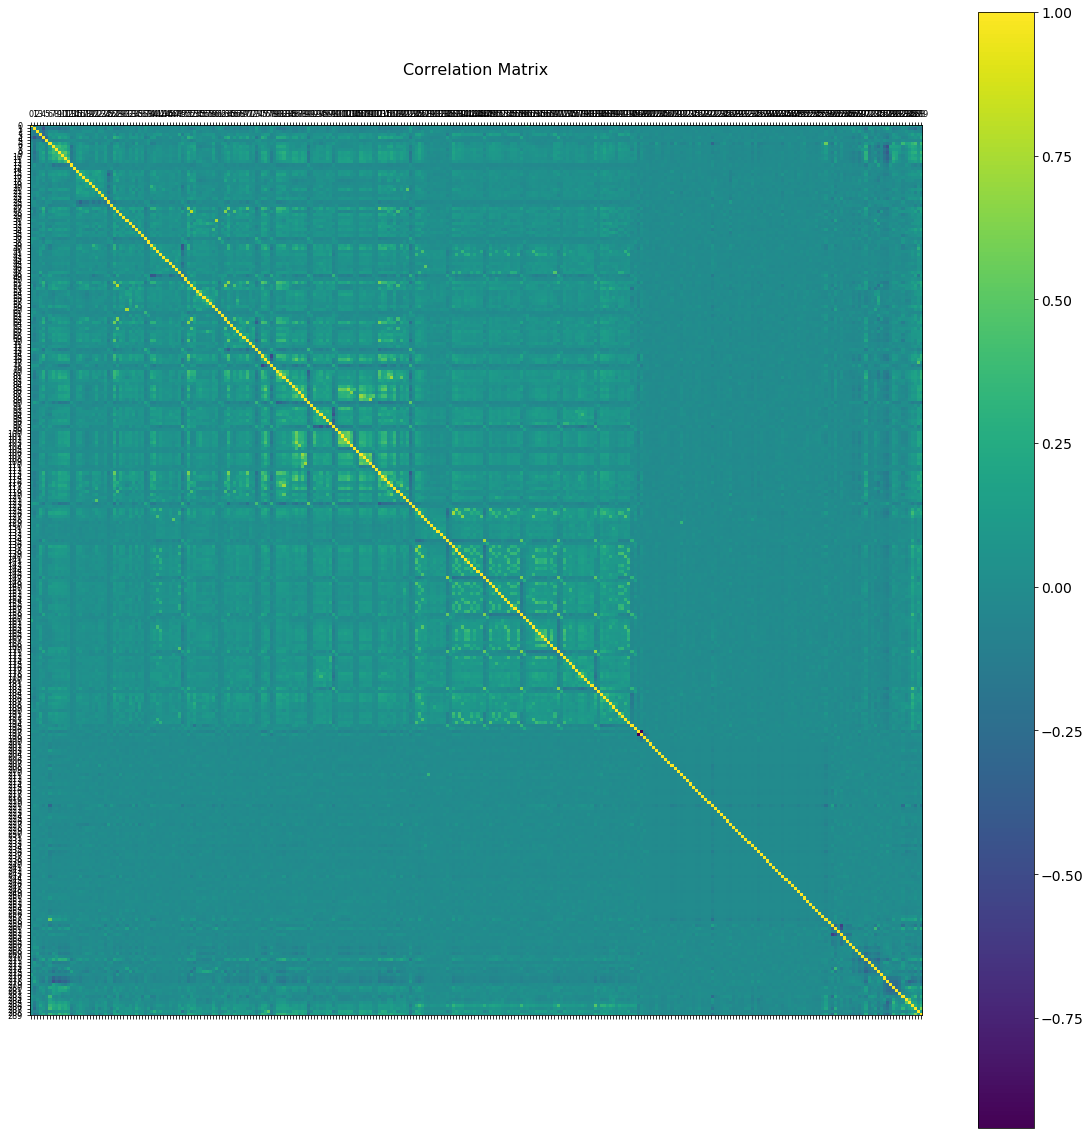

In [61]:
corrMatrix = df_encoded.corr()
# print (corrMatrix)

f = plt.figure(figsize=(20,20))
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df_encoded.shape[1]), df_encoded.index, fontsize=8)
plt.yticks(range(df_encoded.shape[1]), df_encoded.index, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

#### As the size of the matrix is 290 x 290, we cannot visualize it easily. Hence, we will find features which has a correlation greater than a particular threshold.

In [62]:
corr_target = abs(corrMatrix["Q10_Encoded"])
relevant_features = corr_target[corr_target>0.1] #Threshold = 0.1
# print("Relevant features - \n", relevant_features)
len(relevant_features)

43

### Feature selection  - Method 2:

### LassoCV 

LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

In [63]:
X = df_encoded.drop(['Q10_Encoded'], axis=1)
y = df_encoded['Q10_Encoded']

col_feat = X.columns

clf = LassoCV()

# Set a minimum threshold of 0.1
sfm = SelectFromModel(clf, threshold=0.1) #  Selecting features using Lasso regularisation using SelectFromModel
sfm.fit(X, y)


for features in sfm.get_support(indices=True):
    print(col_feat[features])
    
features_selected = X[X.columns[(sfm.get_support())]]


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Q14 Business intelligence software (Salesforce, Tableau, Spotfire, etc.)
Q14 Cloud-based data software & APIs (AWS, GCP, Azure, etc.)
Q9_Part_1_Analyze and understand data to influence product or business decisions
Q9_Part_3_Build prototypes to explore applying machine learning to new areas
Q9_Part_6_Do research that advances the state of the art of machine learning
Q9_Part_7_None of these activities are an important part of my role at work
Q13_Part_2_Coursera
Q13_Part_4_DataCamp
Q13_Part_7_Fast.ai
Q13_Part_10_University Courses (resulting in a university degree)
Q16_Part_5_ MATLAB 
Q16_Part_7_  Spyder  
Q16_Part_8_  Vim / Emacs  
Q16_Part_9_  Notepad++  
Q17_Part_2_ Google Colab 
Q17_Part_11_None
Q18_Part_8_TypeScript
Q20_Part_2_ Matplotlib 
Q20_Part_3_ Altair 
Q20_Part_11_None
Q21_Part_2_GPUs
Q21_Part_4_None / I do not know
Q24_Part_3_Gradient Boosting Machines (xgboost, lightgbm, etc)
Q24_Part_10_Transformer Networks (BERT, gpt-2, etc)
Q24_Part_12_Other
Q25_Part_7_None
Q27_Part_5_No

In [64]:
features_selected.shape

(12497, 105)

##### For the same threshold, we are getting 43 important features from the correlation matrix while we are getting 105 features from LassoCV. 

#### I am considering LassoCV and will train my model using the features selcted by it.


### PCA

As the number of important features selected by LASSO is quite large (105 features), I will be using a dimensionality reduction technique called PCA (Principal component analysis). It is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. Such dimensionality reduction can be a very useful step for visualising and processing high-dimensional datasets, while still retaining as much of the variance in the dataset as possible.

In [65]:
scalar = StandardScaler()
selected = scalar.fit_transform(features_selected)

Cumulative explained variance is = 95.44812725175554 %


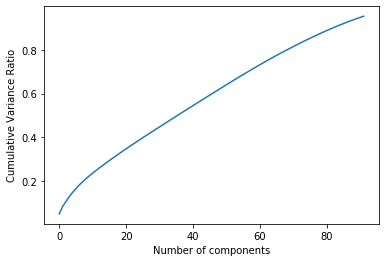

In [66]:
pca = PCA(n_components=92, random_state=0)
X = pca.fit_transform(selected)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative Variance Ratio")

print("Cumulative explained variance is =", np.cumsum(pca.explained_variance_ratio_)[-1]*100, "%")

In [67]:
X.shape

(12497, 92)

After PCA, we have 92 important features to train our model and predict salary.

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## 4. Model Implementation - Logistic Regression

The logistic model is used to model the probability of a certain class or event existing such as pass/fail or win/lose.
Logistic Regression is used when the dependent variable(target) is categorical.
There are times where we need to classify whether a certain scenario is considered as class 0 or class 1 which is in the case of a binary classification regression. For such models, linear regression can be used. But for the linear regression to work, there is a need for setting up a threshold based on which classification can be done. For our example, it can be inferred that linear regression is not suitable for classification problem.

Logistic regression is named for the function used at the core of the method, the logistic function. It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

$$S = (1/(1+e^{-x})$$

The coefficients of the logistic regression algorithm must be estimated from your training data. This is done using maximum-likelihood estimation.

Maximum-likelihood estimation is a common learning algorithm used by a variety of machine learning algorithms, although it does make assumptions about the distribution of your data
The best coefficients would result in a model that would predict a value very close to 1 for the default class and a value very close to 0 for the other class. The intuition for maximum-likelihood for logistic regression is that a search procedure seeks values for the coefficients that minimize the error in the probabilities predicted by the model to those in the data (e.g. probability of 1 if the data is the primary class).

Due to the properties of logistic regression, we cannot directly apply it on our model as it contains more than just 2 classes (15 in our case). The logistic function is only able to classy the data between 2 classes, either 0 or 1. So, we will divide the labels in such a way that we can use logistic regression multiple times, each time classifying between one class vs. the rest. 
As our target data is ordered, we cannot use one vs. rest method to solve this as it will consider one label as class 0 and the rest of them as class 1.

In [68]:
# Test-train split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

I am using the parameter stratify=y to ensure equal distribution of labels in both training data and testing data. This is done because we have skewed distribution of labels as the number of labels with class 0 is much greater than the total number of labels with class 14.

### MODEL 0 - 
#### Encoding class '0' as 0 and the rest to '1'.

In [69]:
y_train_0 = y_train.map({
    0:0,
    1:1,
    2:1,
    3:1,
    4:1,
    5:1,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model0 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model0.fit(X_train, y_train_0)
prob_model0 = LR_model0.predict_proba(X_test)
prob_class0 = prob_model0[:,0]
# prob_class0

### MODEL 1 - 
#### Encoding class 0 and 1 as '0' and the rest to '1'.

In [70]:
y_train_1 = y_train.map({
    0:0,
    1:0,
    2:1,
    3:1,
    4:1,
    5:1,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model1 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model1.fit(X_train, y_train_1)
prob_model1 = LR_model1.predict_proba(X_test)
prob_class1 = prob_model1[:,0] - prob_class0


### MODEL 2 - 
#### Encoding class 0, 1 and 2 as '0' and the rest to '1'.

In [71]:
y_train_2 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:1,
    4:1,
    5:1,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model2 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model2.fit(X_train, y_train_2)
prob_model2 = LR_model2.predict_proba(X_test)
prob_class2 = prob_model2[:,0] - prob_model1[:,0]


### MODEL 3 - 
#### Encoding class 0, 1, 2 and 3 as '0' and the rest to '1'.

In [72]:
y_train_3 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:1,
    5:1,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model3 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model3.fit(X_train, y_train_3)
prob_model3 = LR_model3.predict_proba(X_test)
prob_class3 = prob_model3[:,0] - prob_model2[:,0]


### MODEL 4 - 
#### Encoding class 0, 1, 2, 3 and 4 as '0' and the rest to '1'.

In [73]:
y_train_4 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:1,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model4 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model4.fit(X_train, y_train_4)
prob_model4 = LR_model4.predict_proba(X_test)
prob_class4 = prob_model4[:,0] - prob_model3[:,0]


### MODEL 5 - 
#### Encoding class 0, 1, 2, 3, 4 and 5 as '0' and the rest to '1'.

In [74]:
y_train_5 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:1,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model5 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model5.fit(X_train, y_train_5)
prob_model5 = LR_model5.predict_proba(X_test)
prob_class5 = prob_model5[:,0] - prob_model4[:,0]


### MODEL 6 - 
#### Encoding class 0, 1, 2, 3, 4, 5 and 6 as '0' and the rest to '1'.

In [75]:
y_train_6 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:1,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model6 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model6.fit(X_train, y_train_6)
prob_model6 = LR_model6.predict_proba(X_test)
prob_class6 = prob_model6[:,0] - prob_model5[:,0]


### MODEL 7 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6 and 7 as '0' and the rest to '1'

In [76]:
y_train_7 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:1,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model7 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model7.fit(X_train, y_train_7)
prob_model7 = LR_model7.predict_proba(X_test)
prob_class7 = prob_model7[:,0] - prob_model6[:,0]


### MODEL 8 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7 and 8 as '0' and the rest to '1'

In [77]:
y_train_8 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:1,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model8 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model8.fit(X_train, y_train_8)
prob_model8 = LR_model8.predict_proba(X_test)
prob_class8 = prob_model8[:,0] - prob_model7[:,0]


### MODEL 9 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9 as '0' and the rest to '1'

In [78]:
y_train_9 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:1,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model9 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model9.fit(X_train, y_train_9)
prob_model9 = LR_model9.predict_proba(X_test)
prob_class9 = prob_model9[:,0] - prob_model8[:,0]


### MODEL 10 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7, 8. 9 and 10 as '0' and the rest to '1'

In [79]:
y_train_10 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:0,
    11:1,
    12:1,
    13:1,
    14:1,
})

LR_model10 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model10.fit(X_train, y_train_10)
prob_model10 = LR_model10.predict_proba(X_test)
prob_class10 = prob_model10[:,0] - prob_model9[:,0]


### MODEL 11 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7, 8. 9, 10 and 11 as '0' and the rest to '1'

In [80]:
y_train_11 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:0,
    11:0,
    12:1,
    13:1,
    14:1,
})

LR_model11 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model11.fit(X_train, y_train_11)
prob_model11 = LR_model11.predict_proba(X_test)
prob_class11 = prob_model11[:,0] - prob_model10[:,0]


### MODEL 12 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7, 8. 9, 10, 11 and 12 as '0' and the rest to '1'

In [81]:
y_train_12 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:0,
    11:0,
    12:0,
    13:1,
    14:1,
})

LR_model12 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model12.fit(X_train, y_train_12)
prob_model12 = LR_model12.predict_proba(X_test)
prob_class12 = prob_model12[:,0] - prob_model11[:,0]


### MODEL 13 -
#### Encoding class 0, 1, 2, 3, 4, 5, 6, 7, 8. 9, 10, 11, 12 and 13 as '0' and the rest to '1'

In [82]:
y_train_13 = y_train.map({
    0:0,
    1:0,
    2:0,
    3:0,
    4:0,
    5:0,
    6:0,
    7:0,
    8:0,
    9:0,
    10:0,
    11:0,
    12:0,
    13:0,
    14:1,
})

LR_model13 = LogisticRegression(solver='liblinear', penalty ='l2', C=1, max_iter=100)
LR_model13.fit(X_train, y_train_13)
prob_model13 = LR_model13.predict_proba(X_test)
prob_class13 = prob_model13[:,0] - prob_model12[:,0]


### MODEL 14 -
#### Probability of class 14 = probabilit of class 1 in model 13

In [83]:
prob_class14 = prob_model13[:,1]

#### Creating a dataframe of all the probabilities

In [84]:
prob_array = np.stack([prob_class0, prob_class1, prob_class2, prob_class3, prob_class4, prob_class5, prob_class6, prob_class7,
                       prob_class8, prob_class9, prob_class10, prob_class11, prob_class12, prob_class13, prob_class14], axis=1)

In [85]:
df_prob = pd.DataFrame(prob_array)
df_prob

0         1         2         3         4         5         6  \
0     0.721620  0.155979  0.053099  0.010876  0.011319  0.020218  0.001838   
1     0.071257  0.066523  0.208225  0.264390  0.202001  0.103812  0.043093   
2     0.749451  0.161963  0.056911  0.013288  0.001934  0.006578  0.003247   
3     0.299064  0.221842  0.118596  0.099650  0.125119  0.048109  0.030486   
4     0.210466  0.187710  0.114981  0.112727  0.125892  0.065271  0.040964   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.011165  0.012407  0.011525  0.047487  0.062721  0.069681  0.194283   
3746  0.022293 -0.001253  0.005966  0.005062  0.014377  0.011560  0.003677   
3747  0.005714 -0.002286  0.001383  0.002663  0.000613 -0.000046  0.000120   
3748  0.535798  0.193693  0.139377  0.033818  0.016522  0.027725  0.004677   
3749  0.405896  0.179596  0.120668  0.046488 -0.025708  0.089872  0.033632   

             7         8         9        10        11        12        13  \
0     0.010060  0.003110 -0.000867  0.006795  0.002485 -0.001825  0.002913   
1     0.018660  0.005533  0.007244  0.005464  0.002838  0.000689 -0.000029   
2     0.003138  0.000744 -0.000748  0.000130  0.000837  0.000562  0.000028   
3     0.020539  0.006710  0.006728  0.009485  0.008591  0.001301  0.001460   
4     0.054093  0.038411  0.004499  0.013419  0.015817  0.009239  0.002768   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.202142  0.156282 -0.031442  0.143534  0.002139  0.098792  0.013499   
3746  0.029367  0.031668  0.089396  0.392449  0.162694  0.127770  0.054049   
3747  0.001751  0.005684  0.012854  0.014354  0.094214  0.527308  0.179892   
3748  0.001788 -0.000301  0.008591  0.000068  0.001909 -0.009087  0.010616   
3749  0.049270  0.025497  0.015227  0.022371 -0.000621 -0.013261 -0.006893   

            14  
0     0.002379  
1     0.000300  
2     0.001938  
3     0.002322  
4     0.003743  
...        ...  
3745  0.005785  
3746  0.050925  
3747  0.155782  
3748  0.034807  
3749  0.057964  

[3750 rows x 15 columns]

In [86]:
# Find max of each row and assign the column index - This specifies that what is the probability of each test data (row) and 
# which class it represents. 
df_prob['Predicted Class'] = df_prob.apply(lambda x: x.idxmax(), axis=1)

In [87]:
df_prob

0         1         2         3         4         5         6  \
0     0.721620  0.155979  0.053099  0.010876  0.011319  0.020218  0.001838   
1     0.071257  0.066523  0.208225  0.264390  0.202001  0.103812  0.043093   
2     0.749451  0.161963  0.056911  0.013288  0.001934  0.006578  0.003247   
3     0.299064  0.221842  0.118596  0.099650  0.125119  0.048109  0.030486   
4     0.210466  0.187710  0.114981  0.112727  0.125892  0.065271  0.040964   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.011165  0.012407  0.011525  0.047487  0.062721  0.069681  0.194283   
3746  0.022293 -0.001253  0.005966  0.005062  0.014377  0.011560  0.003677   
3747  0.005714 -0.002286  0.001383  0.002663  0.000613 -0.000046  0.000120   
3748  0.535798  0.193693  0.139377  0.033818  0.016522  0.027725  0.004677   
3749  0.405896  0.179596  0.120668  0.046488 -0.025708  0.089872  0.033632   

             7         8         9        10        11        12        13  \
0     0.010060  0.003110 -0.000867  0.006795  0.002485 -0.001825  0.002913   
1     0.018660  0.005533  0.007244  0.005464  0.002838  0.000689 -0.000029   
2     0.003138  0.000744 -0.000748  0.000130  0.000837  0.000562  0.000028   
3     0.020539  0.006710  0.006728  0.009485  0.008591  0.001301  0.001460   
4     0.054093  0.038411  0.004499  0.013419  0.015817  0.009239  0.002768   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.202142  0.156282 -0.031442  0.143534  0.002139  0.098792  0.013499   
3746  0.029367  0.031668  0.089396  0.392449  0.162694  0.127770  0.054049   
3747  0.001751  0.005684  0.012854  0.014354  0.094214  0.527308  0.179892   
3748  0.001788 -0.000301  0.008591  0.000068  0.001909 -0.009087  0.010616   
3749  0.049270  0.025497  0.015227  0.022371 -0.000621 -0.013261 -0.006893   

            14  Predicted Class  
0     0.002379                0  
1     0.000300                3  
2     0.001938                0  
3     0.002322                0  
4     0.003743                0  
...        ...              ...  
3745  0.005785                7  
3746  0.050925               10  
3747  0.155782               12  
3748  0.034807                0  
3749  0.057964                0  

[3750 rows x 16 columns]

A new column has been added which depicts the model prediction of each test sample and which class it represents to.

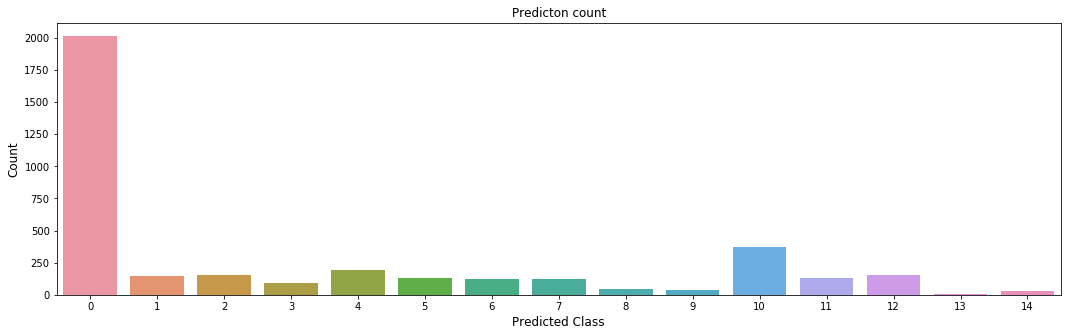

In [88]:
plt.figure(figsize=(18,5))
sb.countplot(x='Predicted Class', data=df_prob)
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Predicton count")
plt.show()
# df_prob['Predicted Class'].value_counts()

We can observe from the above graph that class 0 consists of maximum number of respondents' yearly compensation.
In comparison to the other classes, It might create bias while predicting the classes on our test set.

We cannot plot the bias-viariance trade-off plot on this model as we have implemented 15 different models with different label encodings and each iteration will have different metrics which cannot be used for the overall model.



#### Finding the overall accuracy on the test set:

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In [89]:
acc = accuracy_score(y_test, df_prob['Predicted Class'])
print("Accuracy on the test set is: ", "%.2f" %(acc*100), "%")

Accuracy on the test set is:  38.21 %


**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## 5. HYPERPARAMETER TUNING WITH 10-FOLD CROSS-VALIDATION 



Hyperparameters are important because they directly control the behaviour of the training algorithm and have a significant impact on the performance of the model being trained. 
The process of finding the best parameters for our model is called hyperparameter tuning. It can be done by various algorithms but here, we will be using Grid Search which trains the algorithm for all combinations by using the two set of hyperparameters (learning rate and number of layers) and measures the performance using “Cross Validation” technique. This validation technique gives assurance that our trained model got most of the patterns from the dataset. One of the best methods to do validation by using “K-Fold Cross Validation” which helps to provide ample data for training the model and ample data for validations.

In [90]:
# Create list of all the y_train encoded values which was generated earlier.

Y_LR = [y_train_0, y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_6, y_train_7, y_train_8, y_train_9, y_train_10,
       y_train_11, y_train_12, y_train_13]

print(len(Y_LR))

14


Now we will use GridSearchCV for the hyperparameter tunung. 
Hyperparameters to be tuned: C

Here we will be applying GridSearchCV on our Logistic regression model and run various iterations, each time using a different 'C' value.

In [91]:
LR_opt = LogisticRegression(solver='liblinear', penalty ='l2', max_iter=1000)

parameters = {'C':[0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]} # Parameters to consider.

LR = GridSearchCV(LR_opt, parameters, cv=10, verbose=True) # Hyperparameter tuning with 10-fold cross-validation.

prob_array_LR=[] # Saving all the probabilities of each model in an array.

for i in range(len(Y_LR)):
    LR.fit(X_train, Y_LR[i])
    prob_model = LR.predict_proba(X_test)
    prob_array_LR.append(prob_model)
    print("\n\n", "For model ", i)
    print(LR.best_score_, LR.best_params_) # We can also see the best accuracy score and the best performing parameter.

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




 For model  0
0.793414885103464 {'C': 0.01}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   12.6s finished




 For model  1
0.8061049502686636 {'C': 2}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   12.9s finished




 For model  2
0.8263404595861438 {'C': 1.5}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




 For model  3
0.8349148279410084 {'C': 0.01}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.1s finished




 For model  4
0.851834914827941 {'C': 1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   32.7s finished




 For model  5
0.8631530810563621 {'C': 0.05}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   32.0s finished




 For model  6
0.873670972904996 {'C': 1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   34.6s finished




 For model  7
0.8824739910826569 {'C': 0.5}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   31.8s finished




 For model  8
0.8911626843489197 {'C': 1.5}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.3s finished




 For model  9
0.9011089516405625 {'C': 2}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




 For model  10
0.9230593346290157 {'C': 0.01}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   29.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




 For model  11
0.9424945695667086 {'C': 0.01}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   28.2s finished




 For model  12
0.9697038984794787 {'C': 0.05}
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   22.5s finished




 For model  13
0.9826226134674746 {'C': 0.05}


In [92]:
prob_array_LR_1 = np.array(prob_array_LR)

Extracting all the probabilities from our tuned model

In [93]:
pred_class_grid=[]
prev_prob = [0]*X_test.shape[0]
for i in range(0,14):
    prob_class = prob_array_LR_1[i][:,0]
    final_prob = pd.DataFrame(prob_class)-pd.DataFrame(prev_prob)
    pred_class_grid.append(final_prob)
    prev_prob = prob_class

pred_class_grid.append(prob_array_LR[-1][:,1])

In [94]:
pred_class_grid[14]

array([0.00862962, 0.00508608, 0.00819598, ..., 0.14294457, 0.04323382,
       0.05677928])

In [95]:
df_pred_class_grid = pd.DataFrame(pred_class_grid[0])

for j in range(1,np.array(pred_class_grid).shape[0]):
    temp = pd.DataFrame(pred_class_grid[j])
    df_pred_class_grid[j]=temp
    
df_pred_class_grid

0         1         2         3         4         5         6   \
0     0.699024  0.178705  0.053042 -0.008992  0.031113  0.017761  0.004295   
1     0.093544  0.044081  0.208293  0.263594  0.202883  0.092803  0.054102   
2     0.732649  0.178859  0.056860  0.003039  0.012140  0.005303  0.004522   
3     0.327471  0.193357  0.118681  0.084317  0.140446  0.023261  0.055334   
4     0.241513  0.156580  0.115078  0.094015  0.144590  0.042606  0.063629   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.022221  0.001276  0.011541  0.072559  0.037709  0.092673  0.171291   
3746  0.037512 -0.016536  0.005983  0.019496 -0.000010  0.011997  0.003239   
3747  0.010029 -0.006612  0.001386  0.005852 -0.002567  0.001156 -0.001083   
3748  0.549645  0.179847  0.139436  0.013995  0.036285  0.024865  0.007537   
3749  0.430937  0.154473  0.120747  0.038637 -0.017852  0.109965  0.013539   

            7         8         9         10        11        12        13  \
0     0.009869  0.003362 -0.000741 -0.013895  0.003808  0.011173  0.002844   
1     0.018379  0.005882  0.007205 -0.011266  0.003192  0.013132 -0.000909   
2     0.003030  0.000888 -0.000680 -0.016721 -0.002306  0.016040 -0.001819   
3     0.018873  0.009034  0.006910 -0.031175  0.015368  0.026042  0.002275   
4     0.048550  0.045874  0.005773 -0.048974  0.022481  0.050245  0.004544   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.207645  0.149248 -0.033856  0.125237  0.002559  0.108682  0.014720   
3746  0.028564  0.033497  0.091013  0.334196  0.155650  0.167308  0.056956   
3747  0.001832  0.005596  0.012907  0.088288  0.190639  0.402369  0.147263   
3748  0.002854 -0.002137  0.008340 -0.047876  0.003275  0.027911  0.012789   
3749  0.050512  0.023942  0.015516 -0.019016 -0.002063  0.021610  0.002275   

            14  
0     0.008630  
1     0.005086  
2     0.008196  
3     0.009806  
4     0.013495  
...        ...  
3745  0.016495  
3746  0.071135  
3747  0.142945  
3748  0.043234  
3749  0.056779  

[3750 rows x 15 columns]

In [96]:
df_pred_tuned = df_pred_class_grid.copy()
df_pred_tuned['GridSearch Pred. Class'] = df_pred_tuned.apply(lambda x: x.idxmax(), axis=1)
df_pred_tuned

0         1         2         3         4         5         6  \
0     0.699024  0.178705  0.053042 -0.008992  0.031113  0.017761  0.004295   
1     0.093544  0.044081  0.208293  0.263594  0.202883  0.092803  0.054102   
2     0.732649  0.178859  0.056860  0.003039  0.012140  0.005303  0.004522   
3     0.327471  0.193357  0.118681  0.084317  0.140446  0.023261  0.055334   
4     0.241513  0.156580  0.115078  0.094015  0.144590  0.042606  0.063629   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.022221  0.001276  0.011541  0.072559  0.037709  0.092673  0.171291   
3746  0.037512 -0.016536  0.005983  0.019496 -0.000010  0.011997  0.003239   
3747  0.010029 -0.006612  0.001386  0.005852 -0.002567  0.001156 -0.001083   
3748  0.549645  0.179847  0.139436  0.013995  0.036285  0.024865  0.007537   
3749  0.430937  0.154473  0.120747  0.038637 -0.017852  0.109965  0.013539   

             7         8         9        10        11        12        13  \
0     0.009869  0.003362 -0.000741 -0.013895  0.003808  0.011173  0.002844   
1     0.018379  0.005882  0.007205 -0.011266  0.003192  0.013132 -0.000909   
2     0.003030  0.000888 -0.000680 -0.016721 -0.002306  0.016040 -0.001819   
3     0.018873  0.009034  0.006910 -0.031175  0.015368  0.026042  0.002275   
4     0.048550  0.045874  0.005773 -0.048974  0.022481  0.050245  0.004544   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.207645  0.149248 -0.033856  0.125237  0.002559  0.108682  0.014720   
3746  0.028564  0.033497  0.091013  0.334196  0.155650  0.167308  0.056956   
3747  0.001832  0.005596  0.012907  0.088288  0.190639  0.402369  0.147263   
3748  0.002854 -0.002137  0.008340 -0.047876  0.003275  0.027911  0.012789   
3749  0.050512  0.023942  0.015516 -0.019016 -0.002063  0.021610  0.002275   

            14  GridSearch Pred. Class  
0     0.008630                       0  
1     0.005086                       3  
2     0.008196                       0  
3     0.009806                       0  
4     0.013495                       0  
...        ...                     ...  
3745  0.016495                       7  
3746  0.071135                      10  
3747  0.142945                      12  
3748  0.043234                       0  
3749  0.056779                       0  

[3750 rows x 16 columns]

We have some probability values which are negative (not possible). As these negative values are very small, we can replace those values by 0.

In [97]:
df_pred_tuned_zero = df_pred_class_grid.mask(df_pred_class_grid < 0, 0)
df_pred_tuned_zero

0         1         2         3         4         5         6   \
0     0.699024  0.178705  0.053042  0.000000  0.031113  0.017761  0.004295   
1     0.093544  0.044081  0.208293  0.263594  0.202883  0.092803  0.054102   
2     0.732649  0.178859  0.056860  0.003039  0.012140  0.005303  0.004522   
3     0.327471  0.193357  0.118681  0.084317  0.140446  0.023261  0.055334   
4     0.241513  0.156580  0.115078  0.094015  0.144590  0.042606  0.063629   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.022221  0.001276  0.011541  0.072559  0.037709  0.092673  0.171291   
3746  0.037512  0.000000  0.005983  0.019496  0.000000  0.011997  0.003239   
3747  0.010029  0.000000  0.001386  0.005852  0.000000  0.001156  0.000000   
3748  0.549645  0.179847  0.139436  0.013995  0.036285  0.024865  0.007537   
3749  0.430937  0.154473  0.120747  0.038637  0.000000  0.109965  0.013539   

            7         8         9         10        11        12        13  \
0     0.009869  0.003362  0.000000  0.000000  0.003808  0.011173  0.002844   
1     0.018379  0.005882  0.007205  0.000000  0.003192  0.013132  0.000000   
2     0.003030  0.000888  0.000000  0.000000  0.000000  0.016040  0.000000   
3     0.018873  0.009034  0.006910  0.000000  0.015368  0.026042  0.002275   
4     0.048550  0.045874  0.005773  0.000000  0.022481  0.050245  0.004544   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.207645  0.149248  0.000000  0.125237  0.002559  0.108682  0.014720   
3746  0.028564  0.033497  0.091013  0.334196  0.155650  0.167308  0.056956   
3747  0.001832  0.005596  0.012907  0.088288  0.190639  0.402369  0.147263   
3748  0.002854  0.000000  0.008340  0.000000  0.003275  0.027911  0.012789   
3749  0.050512  0.023942  0.015516  0.000000  0.000000  0.021610  0.002275   

            14  
0     0.008630  
1     0.005086  
2     0.008196  
3     0.009806  
4     0.013495  
...        ...  
3745  0.016495  
3746  0.071135  
3747  0.142945  
3748  0.043234  
3749  0.056779  

[3750 rows x 15 columns]

After replacing all negative probabilities to zero, we will normalize the probabilities so that their sum across all 15 classes should be equal to 1.

In [98]:
df_normalized = df_pred_tuned_zero.div(df_pred_tuned_zero.sum(axis=1), axis=0)
df_normalized

0         1         2         3         4         5         6   \
0     0.682889  0.174580  0.051818  0.000000  0.030395  0.017351  0.004195   
1     0.092419  0.043551  0.205788  0.260423  0.200442  0.091686  0.053452   
2     0.717210  0.175090  0.055662  0.002975  0.011885  0.005191  0.004427   
3     0.317571  0.187511  0.115093  0.081768  0.136200  0.022558  0.053661   
4     0.230237  0.149270  0.109706  0.089626  0.137839  0.040617  0.060658   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.021493  0.001234  0.011163  0.070183  0.036474  0.089638  0.165681   
3746  0.036902  0.000000  0.005886  0.019179  0.000000  0.011802  0.003187   
3747  0.009927  0.000000  0.001372  0.005792  0.000000  0.001145  0.000000   
3748  0.523465  0.171281  0.132795  0.013329  0.034557  0.023680  0.007178   
3749  0.414788  0.148684  0.116222  0.037190  0.000000  0.105844  0.013032   

            7         8         9         10        11        12        13  \
0     0.009641  0.003285  0.000000  0.000000  0.003720  0.010915  0.002779   
1     0.018158  0.005811  0.007118  0.000000  0.003153  0.012974  0.000000   
2     0.002966  0.000870  0.000000  0.000000  0.000000  0.015702  0.000000   
3     0.018303  0.008761  0.006701  0.000000  0.014904  0.025255  0.002206   
4     0.046283  0.043733  0.005504  0.000000  0.021432  0.047899  0.004332   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.200845  0.144361  0.000000  0.121136  0.002476  0.105123  0.014238   
3746  0.028099  0.032952  0.089531  0.328756  0.153117  0.164584  0.056029   
3747  0.001814  0.005540  0.012776  0.087391  0.188703  0.398282  0.145768   
3748  0.002718  0.000000  0.007943  0.000000  0.003119  0.026581  0.012180   
3749  0.048619  0.023044  0.014935  0.000000  0.000000  0.020801  0.002190   

            14  
0     0.008430  
1     0.005025  
2     0.008023  
3     0.009509  
4     0.012865  
...        ...  
3745  0.015955  
3746  0.069978  
3747  0.141493  
3748  0.041175  
3749  0.054652  

[3750 rows x 15 columns]

In [99]:
df_normalized['GridSearch Pred. Class'] = df_normalized.apply(lambda x: x.idxmax(), axis=1)
df_normalized

0         1         2         3         4         5         6  \
0     0.682889  0.174580  0.051818  0.000000  0.030395  0.017351  0.004195   
1     0.092419  0.043551  0.205788  0.260423  0.200442  0.091686  0.053452   
2     0.717210  0.175090  0.055662  0.002975  0.011885  0.005191  0.004427   
3     0.317571  0.187511  0.115093  0.081768  0.136200  0.022558  0.053661   
4     0.230237  0.149270  0.109706  0.089626  0.137839  0.040617  0.060658   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.021493  0.001234  0.011163  0.070183  0.036474  0.089638  0.165681   
3746  0.036902  0.000000  0.005886  0.019179  0.000000  0.011802  0.003187   
3747  0.009927  0.000000  0.001372  0.005792  0.000000  0.001145  0.000000   
3748  0.523465  0.171281  0.132795  0.013329  0.034557  0.023680  0.007178   
3749  0.414788  0.148684  0.116222  0.037190  0.000000  0.105844  0.013032   

             7         8         9        10        11        12        13  \
0     0.009641  0.003285  0.000000  0.000000  0.003720  0.010915  0.002779   
1     0.018158  0.005811  0.007118  0.000000  0.003153  0.012974  0.000000   
2     0.002966  0.000870  0.000000  0.000000  0.000000  0.015702  0.000000   
3     0.018303  0.008761  0.006701  0.000000  0.014904  0.025255  0.002206   
4     0.046283  0.043733  0.005504  0.000000  0.021432  0.047899  0.004332   
...        ...       ...       ...       ...       ...       ...       ...   
3745  0.200845  0.144361  0.000000  0.121136  0.002476  0.105123  0.014238   
3746  0.028099  0.032952  0.089531  0.328756  0.153117  0.164584  0.056029   
3747  0.001814  0.005540  0.012776  0.087391  0.188703  0.398282  0.145768   
3748  0.002718  0.000000  0.007943  0.000000  0.003119  0.026581  0.012180   
3749  0.048619  0.023044  0.014935  0.000000  0.000000  0.020801  0.002190   

            14  GridSearch Pred. Class  
0     0.008430                       0  
1     0.005025                       3  
2     0.008023                       0  
3     0.009509                       0  
4     0.012865                       0  
...        ...                     ...  
3745  0.015955                       7  
3746  0.069978                      10  
3747  0.141493                      12  
3748  0.041175                       0  
3749  0.054652                       0  

[3750 rows x 16 columns]

Accuracy of our tuned model:

In [100]:
acc_tuned = accuracy_score(y_test, df_normalized['GridSearch Pred. Class'])

#### Comparing accuracies of our untuned and tuned models-

In [101]:
print("Accuracy before tuning: ", "%.2f" %(acc*100), "%")
print("Accuracy after tuning: ", (acc_tuned)*100, "%")

Accuracy before tuning:  38.21 %
Accuracy after tuning:  38.4 %


We can observe that hyperparameter tuning has helped us increase the model performance by 0.2%.

The accuracy score might seem very less, but it is actually normal because we have 15 different classes or labels to predict from and hence the model is 38.4% accurate in predicting the correct class. 

#### Plotting probability distribution of any 5 random test samples and determing the salary class.

C:\Users\Hp\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning:


The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.



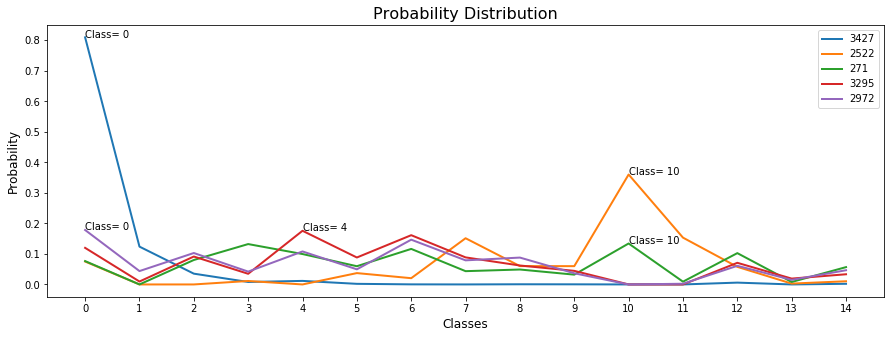

In [102]:
np.random.seed(20)
samples = np.random.randint(0, df_normalized.shape[0], 5)
xticks = np.arange(0, 15, 1)

plt.figure(figsize=(15,5))
for i in samples:
    xmax = xticks[np.argmax(df_normalized.iloc[i, :-1])]
    ymax = df_normalized.iloc[i, :-1].max()
    plt.plot(df_normalized.iloc[i, :-1], label=i, linewidth=2)
    plt.xticks(xticks)
    plt.annotate("Class= {}" .format(xmax), xy=(xmax, ymax), fontsize=10)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title("Probability Distribution", fontsize=16)
plt.legend()    

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## 6. Testing and discussion

In this section, we will discuss the model accuracies as well as their precision, recall and f1-scores.  

### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

The confusion matrix is usually useful for binary classification models where the model has to classify between class 0 and class 1. It is extremely useful for measuring Recall, Precision, Specificity, Accuracy and most importantly AUC-ROC Curve.
As our model consists of 15 different classes, we can use this technique to determine only the precision, recall and f1-score.
    
The confusion matrix is a table with 4 different combinations of predicted and actual values.
These rows and columns are termed as True Positive, True Negative, False Positive and False Negative.

**True Positive:** - You predicted positive and it’s true.

**True Negative:** - You predicted negative and it’s true.

**False Positive: (Type 1 Error)** - You predicted positive and it’s false.

**False Negative: (Type 2 Error)** - You predicted negative and it’s false.

$$Precision = TP/(TP+FP)$$
$$Recall = TP/(TP+FN)$$
$$F1-SCORE = (2*recall*precision)/(recall + precision)$$

Recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.
The F1 score is the harmonic mean of precision and recall taking both metrics into account.

There is a trade-off in the metrics we choose to maximize. In the case of recall, when we increase the recall, we decrease the precision and vice-versa.
If the precision is 1.0 (no false positives), our recall will be very low because we will still have many false negatives. If we have a recall of 1.0, our precision will be very low.

#### Calculation and plotting the confusion matrix

In [103]:
cm = confusion_matrix(y_test, df_normalized['GridSearch Pred. Class'])
cm_matrix = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis] # Normalization 

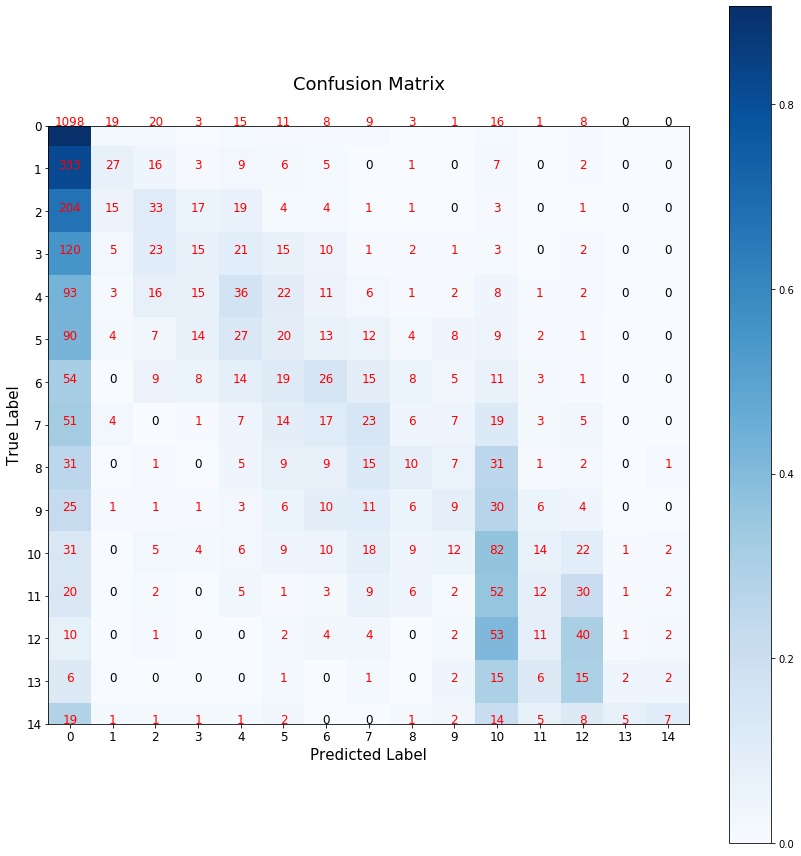

In [104]:
plt.figure(figsize=(12,12))
plt.imshow(cm_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=18, y = 1.05)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, fontsize=12)
plt.yticks(tick_marks, fontsize=12)
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 0:
            color = 'red'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=12)
        
plt.tight_layout()        

#### Comparing the properties of both tuned and untuned models

In [105]:
Tuned_report = classification_report(y_test, df_normalized['GridSearch Pred. Class'])
Untuned_report = classification_report(y_test, df_prob['Predicted Class'])

print("Classification report of untuned model\n", Untuned_report)
print("\n-----------------------\n")
print("Classification report of tuned model\n", Tuned_report)

Classification report of untuned model
               precision    recall  f1-score   support

           0       0.53      0.88      0.66      1212
           1       0.29      0.10      0.15       409
           2       0.23      0.12      0.15       302
           3       0.15      0.06      0.09       218
           4       0.18      0.16      0.17       216
           5       0.13      0.08      0.10       211
           6       0.22      0.16      0.18       173
           7       0.17      0.13      0.14       157
           8       0.15      0.06      0.08       122
           9       0.17      0.05      0.08       113
          10       0.21      0.35      0.26       225
          11       0.16      0.14      0.15       145
          12       0.32      0.38      0.35       130
          13       0.20      0.04      0.07        50
          14       0.36      0.15      0.21        67

    accuracy                           0.38      3750
   macro avg       0.23      0.19      0

In [106]:
# precision = (0.50,0.34,0.24,0.18,0.21,0.14,0.20,0.18,0.17,0.15,0.23,0.18,0.28,0.20,0.44)
# recall = (0.91,0.07,0.11,0.07,0.17,0.09,0.15,0.15,0.08,0.08,0.36,0.08,0.31,0.04,0.10)
# f1_score = (0.65,0.11,0.15,0.10,0.19,0.11,0.17,0.16,0.11,0.10,0.28,0.11,0.29,0.07,0.17)

# df_normalized_report = pd.DataFrame({'precision': precision,'recall': recall,'f1_score': f1_score})
# df_normalized_report

The above 2 tables represent the precisoIn, recall and f1-scores of the original logistic regression model and the tuned model.

We can observe that the precision of the tuned model increased by a small amount while the recall score remained the same.

In our dataset, the maximum number of reSpondents' yearly compensation lie in the range 0-9,999 USD which outnumbers all the other salary ranges. Due to this, the target data becomes skewed as there are more number of class 0's  and quite less for other classes. As seen from the confusion matrix, the relation between true value of label 0 and predicted value of label 0 is very high in comparison to other predictions. We can also see that the recall scores for all the classes except for class 0 are quite low.
Hence the model suffers from **high bias**.